In [55]:
import collections
import itertools
import re
import string
import timeit

import matplotlib.pyplot as plt
import nltk
#nltk.download('popular')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.api import StringTokenizer
from nltk.tokenize import TweetTokenizer
import numpy as np
import pandas as pd
import sklearn

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud

from utils import *
from topic_utils import *

# Text processing

## Pipeline:
We are starting with a series of strings representing individual tweets. We can perform our analysis on
- individual tweets
- all tweets for a grouping of the dataframe (e.g. group by userid)
- all tweets in the corpus

In addition,
- hashtags and urls are already in a separate column, as a list of strings.

In general, we want to convert tweet text into tokens for analysis. We will make utility functions which anticipate tokenizing for these levels of analysis.

1. Individual tweets are strings; groups of tweets are lists of strings
1. Preprocessing:
    1. Remove uninformative symbols
    1. Remove 'RT'
    1. Replace urls, hashtags, and @-mentions with generic tokens
    1. Remove stopwords
    1. Lemmatize
1. Apply preprocessing to column of strings OR column of lists of strings
    - Treat column of strings as a single list of strings

In [56]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')

In [57]:
df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]

In [58]:
campaign = df[df['campaign'] == 'iran202012']
campaign_users = user_df[user_df['campaign'] == 'iran202012']

### Pipeline usage

Aggregation for tweet text can be defined as joining tweet strings into a list of strings:

In [59]:
string_agg = lambda x: list(x)

user_tweets = (campaign
               .groupby('userid')[['tweet_text']]
               .agg(string_agg)
              )
user_tweets.head()

,tweet_text
userid,
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=,[America and the way its government treats its...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=,[@ManotoNews اگه ایران به یمن و مقاومت کمک نکن...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=,[People are not silent! This structure must ch...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=,[El pueblo indígena Kayapo cerró una important...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=,[@VoteMarsha Why Women Prefer to Vote for an r...


We can test our pipeline for tokenizing the datasets by aggregating all tweets for each user, allowing us to characterize users by the overall contents of their activity.

In [60]:
def make_tokens(list_of_strings,
                stop_words=[*stopwords.words(),
                          '<-url->', '<-@->', '<-#->', 
                          '...','`',',','-',"'"]):
    """Apply preprocessing and tokenization to a list of strings.
    Usage: 
            output = make_tokens(series_of_strings)

            output = df.apply(make_tokens)
            
    Return:
        A list of lists of tokens for each string.
    """    
    
    t1 = default_timer()

    processed_strings = [preprocess_string(string)
                         for string in list_of_strings]

    tokenized_strings = [tokenize_string(string,
                                         stop_words)
                          for string in processed_strings]
                         
    t2 = default_timer()
    print('elapsed', t2 - t1)
    
    return tokenized_strings

In [61]:
(user_tweets['tweet_text'].head(1)
               .map(make_tokens))

elapsed 0.02680861300905235


userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=    [[america, way, government, treats, people, mu...
Name: tweet_text, dtype: object

In [62]:
user_tokens = (user_tweets['tweet_text']
               .map(make_tokens)
               .map(long_list)

elapsed 0.027946376998443156
elapsed 0.04004265199182555
elapsed 0.14334002500982024
elapsed 0.532796765997773
elapsed 4.50427655299427
elapsed 3.7145453020057175
elapsed 2.1725544380024076
elapsed 0.8888913700066041
elapsed 4.31270734599093
elapsed 0.37190166700747795
elapsed 0.09599949102266692
elapsed 91.4447370209964
elapsed 0.1440815450041555
elapsed 0.2014987860166002
elapsed 0.09554236300755292
elapsed 0.08554566101520322
elapsed 0.035950055986177176
elapsed 0.012839925999287516
elapsed 0.0015463939926121384
elapsed 0.21606406097998843
elapsed 0.5640427450125571
elapsed 0.2078168320003897
elapsed 0.509346839011414
elapsed 0.0015171200211625546
elapsed 2.118762907019118
elapsed 0.019848054012982175
elapsed 0.93330994900316
elapsed 2.1461638470063917
elapsed 0.032568359980359674
elapsed 0.0008848980069160461
elapsed 0.031049962999532
elapsed 0.0836667460098397
elapsed 0.07035798000288196
elapsed 0.4868014499952551
elapsed 0.12105668798903935
elapsed 0.016730534989619628
elapsed 0.

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     [[america, way, government, treats, people, mu...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=    [[اگه, ایران, یمن, و, مقاومت, کمک, نکنه, خاک, ...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    [[people, silent, structure, must, change], [h...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     [[pueblo, indígena, kayapo, cerró, impoante, c...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=    [[women, prefer, vote, rapest, pedophile, real...
                                                                      ...                        
y3KkURpZFjT+WeW9e6BcxBYRg311F8fz1eJ647ahQc=     [[good, look, tweet, agree, like], [#], [sever...
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=     [[hapus, zionisme, hapus, penjajahan, israel, ...
zFlH+vHUhiZD2qvvCLYyiU76qOha9+iYxCn1NVmzw=      [[karl, marx, leader, nothing, dems, asking, c...
zTUtu8WZ3RwxnwgMsYXnTU107UXsn4MQU5wrg8IDOU=     [[sick, tired, lied], [amazing], [go, vote, be...
zk4khaX7A3XhX

In [151]:
user_tokens

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     [america, way, government, treats, people, mus...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=    [اگه, ایران, یمن, و, مقاومت, کمک, نکنه, خاک, ت...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    [people, silent, structure, must, change, hell...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     [pueblo, indígena, kayapo, cerró, impoante, ca...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=    [women, prefer, vote, rapest, pedophile, reall...
                                                                      ...                        
y3KkURpZFjT+WeW9e6BcxBYRg311F8fz1eJ647ahQc=     [good, look, tweet, agree, like, #, severe, ha...
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=     [hapus, zionisme, hapus, penjajahan, israel, l...
zFlH+vHUhiZD2qvvCLYyiU76qOha9+iYxCn1NVmzw=      [karl, marx, leader, nothing, dems, asking, cr...
zTUtu8WZ3RwxnwgMsYXnTU107UXsn4MQU5wrg8IDOU=     [sick, tired, lied, amazing, go, vote, better,...
zk4khaX7A3XhX

### Count word frequencies

In [63]:
def word_frequency(list_of_words):
    """
    Return:
        dict of {'word':'frequency'} sorted by frequency (high to low)
    """
    counts = collections.Counter(list_of_words)
    
    return dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

In [114]:
corpus_freq_dict = word_frequency(long_list(user_tokens))
corpus_freq_dict

{'…': 57903,
 'via': 40982,
 '’': 34702,
 'و': 32049,
 'completa': 25234,
 '-': 24858,
 'trump': 22582,
 '‘': 21534,
 'irán': 18853,
 '“': 18755,
 'eeuu': 18729,
 'yang': 18359,
 '”': 17519,
 '\u200c': 16381,
 '،': 15993,
 'از': 15338,
 'video': 14312,
 'که': 14106,
 'در': 13904,
 'historia': 13126,
 '😂': 12427,
 'israel': 12269,
 'nota': 11551,
 'presidente': 11395,
 'people': 11139,
 'palestina': 9959,
 'gobierno': 9752,
 'silver': 9506,
 'biden': 9431,
 '؟': 9212,
 'را': 8810,
 'us': 8408,
 'این': 8281,
 'siria': 8101,
 'َ': 8006,
 'با': 7964,
 'iraní': 7619,
 'país': 7290,
 'uploaded': 6882,
 'ejército': 6880,
 'mueos': 6699,
 'است': 6268,
 'nuevo': 6135,
 'fuerzas': 5988,
 'added': 5639,
 'ataque': 5634,
 'terroristas': 5628,
 'militar': 5510,
 'playlist': 5423,
 'president': 5318,
 'crisis': 5273,
 'رو': 5235,
 'orang': 5211,
 'amp': 5102,
 'pide': 5067,
 'vote': 5056,
 'xttxkplli': 5019,
 'china': 4987,
 'tras': 4951,
 'acuerdo': 4943,
 'price': 4930,
 'guerra': 4882,
 'mundo': 

In [66]:
top_user = (campaign
           .groupby('userid')
           .size()
           .idxmax())
user_tweets.loc[top_user]

tweet_text    [¡Quedan 3 episodios para el final!\nSerie "El...
Name: 213589457, dtype: object

In [72]:
top_user_tokens = long_list(user_tokens.loc[top_user])

In [115]:
top_user_tokens[:20]

['¡',
 'quedan',
 'episodios',
 'final',
 'serie',
 'profeta',
 'josé',
 'días',
 'gmt',
 'repite',
 'nicaragua',
 'país',
 'seguro',
 'centroamérica',
 'competencia',
 'militares',
 'israelíes',
 'matar',
 'palestinos',
 'construcción']

In [116]:
document_freq_dict = word_frequency(top_user_tokens)

## Word cloud

In [75]:
def visualize(data,
              from_frequencies=True,
              limit=100,
              color=(150,50,50)):
    """
    """
    cloud = WordCloud(background_color="white",
                  prefer_horizontal=0.9,
                  max_font_size=40,
                  relative_scaling=.5,
                  color_func=lambda *args,**kwargs:color)
    
    data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))
    
    if from_frequencies:
        cloud.generate_from_frequencies(data)
    else:
        cloud.generate(data)
    
    fig, ax = plt.subplots()
    ax.imshow(cloud)
    ax.axis('off')
    
    return fig

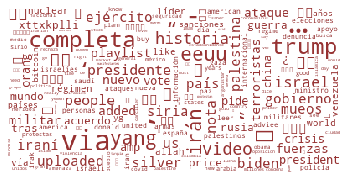

In [76]:
# TODO: render Arabic
fig = visualize(corpus_freq_dict)

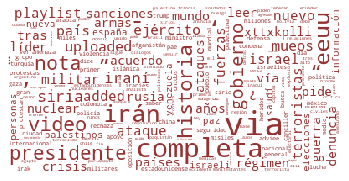

In [77]:
fig = visualize(document_freq_dict)

## Vectorizing

Using sklearn's Vectorizers to turn the corpus into a text-term matrix allows us to easily count tokens, and count n-grams as well as single-word tokens.

In [78]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

In [90]:
def ngram_freq_matrix(list_of_tokens,
                      vectorizer,
                      stop_words=None,
                      ngram_range=(1,2),
                      tokenizer=None,):
    """
    Args: 
       strings_series: list of lists of strings
       stop_words: a list of stop words or the string 'english' to use a
                   built-in English language stop word list.
                   Default: no stop words
       ngram_range: a single int, or a 2 tuple representing the range of ngrams to count.
                    Default: (1,2); counts 1- and 2- grams.
    Return:
       dataframe of counts indexed by n-gram
    """
    if tokenizer is None:
        tokenizer = TweetTokenizer(preserve_case=False,
                                           reduce_len=True,
                                           strip_handles=True)
    if stop_words is None:
        stop_words = [*stopwords.words(),
                      '<-url->', '<-@->', '<-#->', 
                      '...','`',',','-',"'"]
    
    ngram_freq_matrix = vectorizer.fit_transform(list_of_tokens)
    ngrams = vectorizer.get_feature_names()

    ngram_frequencies = ngram_freq_matrix.sum(axis=0).tolist()[0]
    freq_dict = dict(zip(ngrams, ngram_frequencies))
    
    return ngram_freq_matrix, freq_dict

In [136]:
vectorizer = CountVectorizer(analyzer='word',
                                 strip_accents='ascii',
                                 stop_words=[*stopwords.words(),
                                              '<-url->', '<-@->', '<-#->', 
                                              '...','`',',','-',"'"],
                                 ngram_range=(1,2),
                                 tokenizer=TweetTokenizer(preserve_case=False,
                                           reduce_len=True,
                                           strip_handles=True).tokenize
                                )

documents_list = (user_tweets['tweet_text']
                    .map(long_string)
                    .map(preprocess_string)
                   )
documents_list

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     america and the way its government treats its ...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=     اگه ایران به یمن و مقاومت کمک نکنه خاک تو سرش...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    people are not silent this structure must chan...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     el pueblo indígena kayapo cerró una impoante c...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=     why women prefer to vote for an rapest pedoph...
                                                                      ...                        
y3KkURpZFjT+WeW9e6BcxBYRg311F8fz1eJ647ahQc=     take a good look at  and tweet me if you agree...
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=     hapus zionisme hapus penjajahan\n\nisrael ke l...
zFlH+vHUhiZD2qvvCLYyiU76qOha9+iYxCn1NVmzw=      karl marx is the leader of these do nothing de...
zTUtu8WZ3RwxnwgMsYXnTU107UXsn4MQU5wrg8IDOU=     i am sick and tired of being lied to by  amazi...
zk4khaX7A3XhX

In [132]:
matrix, ngrams = ngram_freq_matrix(documents_list,
                                   vectorizer)

/home/sarah/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['.', '?', '^', 'acaba', 'acesti', 'aiba', 'altal', 'altalaban', 'altms', 'amig', 'arasnda', 'arrol', 'artq', 'aslnda', 'astia', 'ate', 'aveti', 'avra', 'avro', 'azert', 'aztan', 'azutan', 'bade', 'bae', 'bar', 'baz', 'bel', 'belul', 'bes', 'bilr', 'birkac', 'birsey', 'bizlr', 'blk', 'bos', 'brzcas', 'brzkone', 'bunlarn', 'butun', 'bzi', 'bzn', 'caci', 'carei', 'caror', 'carui', 'cate', 'cati', 'catva', 'cem', 'cemer', 'cemerkoli', 'cemu', 'cemur', 'cemurkoli', 'ceprav', 'ceravno', 'cesa', 'cesar', 'cesarkoli', 'cetrta', 'cetrte', 'cetrtega', 'cetrtem', 'cetrtemu', 'cetrti', 'cetrtih', 'cetrtim', 'cetrtima', 'cetrtimi', 'cetrto', 'cetudi', 'cez', 'cezenj', 'ceznje', 'cigar', 'cigav', 'cigava', 'cigave', 'cigavega', 'cigavem', 'cigavemu', 'cigavi', 'cigavih', 'cigavim', 'cigavima', '

In [133]:
matrix

<209x2032148 sparse matrix of type '<class 'numpy.int64'>'
	with 2719099 stored elements in Compressed Sparse Row format>

In [134]:
sorted(ngrams.items(), key=lambda item: item[1], reverse=True)[:20]

[('via', 45596),
 ('completa', 25234),
 ('iran', 22380),
 ('trump', 21833),
 ('eeuu', 18729),
 ('yang', 18345),
 ('video', 15955),
 ('historia', 13126),
 ('historia completa', 12192),
 ('israel', 12142),
 ('nota', 11551),
 ('nota completa', 11445),
 ('presidente', 11398),
 ('people', 11089),
 ('palestina', 9948),
 ('gobierno', 9752),
 ('silver', 9501),
 ('biden', 9379),
 ('us', 8403),
 ('siria', 8101)]

# Topic extraction

Tutorial: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#

In [87]:
# suggested scale
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20

## Latent Dirichlet Allocation (LDA)

Latent Dirichlet Allocation is a generative probabilistic model which models a corpus as a random mixture of topics and uses the observed words to fit latent variables describing the mixture of topics and the distribution of words in the documents of the corpus.

A corpus consists of $D$ documents ($\sim$vector samples) of $N$ words ($\sim$entry samples) described by $K$ topics ($\sim$classes).

1. For each topic $k \in K$, draw $\beta_{k} \sim \text{Dirichlet}(\eta)$. This represents the probability of a word appearing in topic $k$.


1. For each document $d \in D$: draw the topic proportions $\theta_{d} \sim \text{Dirichlet}(\alpha).$

1. For each word $i$ in document $D$:
    1. Draw the topic assignment $z_{di} \sim \text{Multinomial}(\theta_{d})$
    2. Draw the observed word $w_{ij} \sim \text{Multinomial}(\beta_{z_{di}})$

For parameter estimation, the posterior distribution is:
$$
p(z,\theta,\beta\mid w,\alpha,\eta) = \frac{p(z,\theta,\beta\mid\alpha,\eta)}{p(w\mid\alpha,\eta)}
$$

Variational Bayesian method uses a simpler distribution to approximate the posterior distribution and optimizes parameters in an expectation-minimization procedure. Variational parameters are optimized to maximize the Evidence Lower Bound (ELBO) - maximizing ELBO is equivalent to minimizing the Kullback-Leibler (KL) divergence between the estimate $q$ and the true posterior $p$.

In [137]:
t1 = default_timer()

tf = vectorizer.fit_transform(documents_list)

t2 = default_timer()

print('elapsed: {}'.format(t2 - t1))

elapsed: 31.402734208997572


In [138]:
print(('n_samples: {}\nn_features: {}')
      .format(n_samples, n_features))

lda = LatentDirichletAllocation(n_components=n_components, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t1 = default_timer()

lda.fit(tf)

t2 = default_timer()

print('elapsed: {}'.format(t2 - t1))

n_samples: 2000
n_features: 1000
elapsed: 29.642652180977166


Results with sklearn preprocessing applied by CountVectorizer:

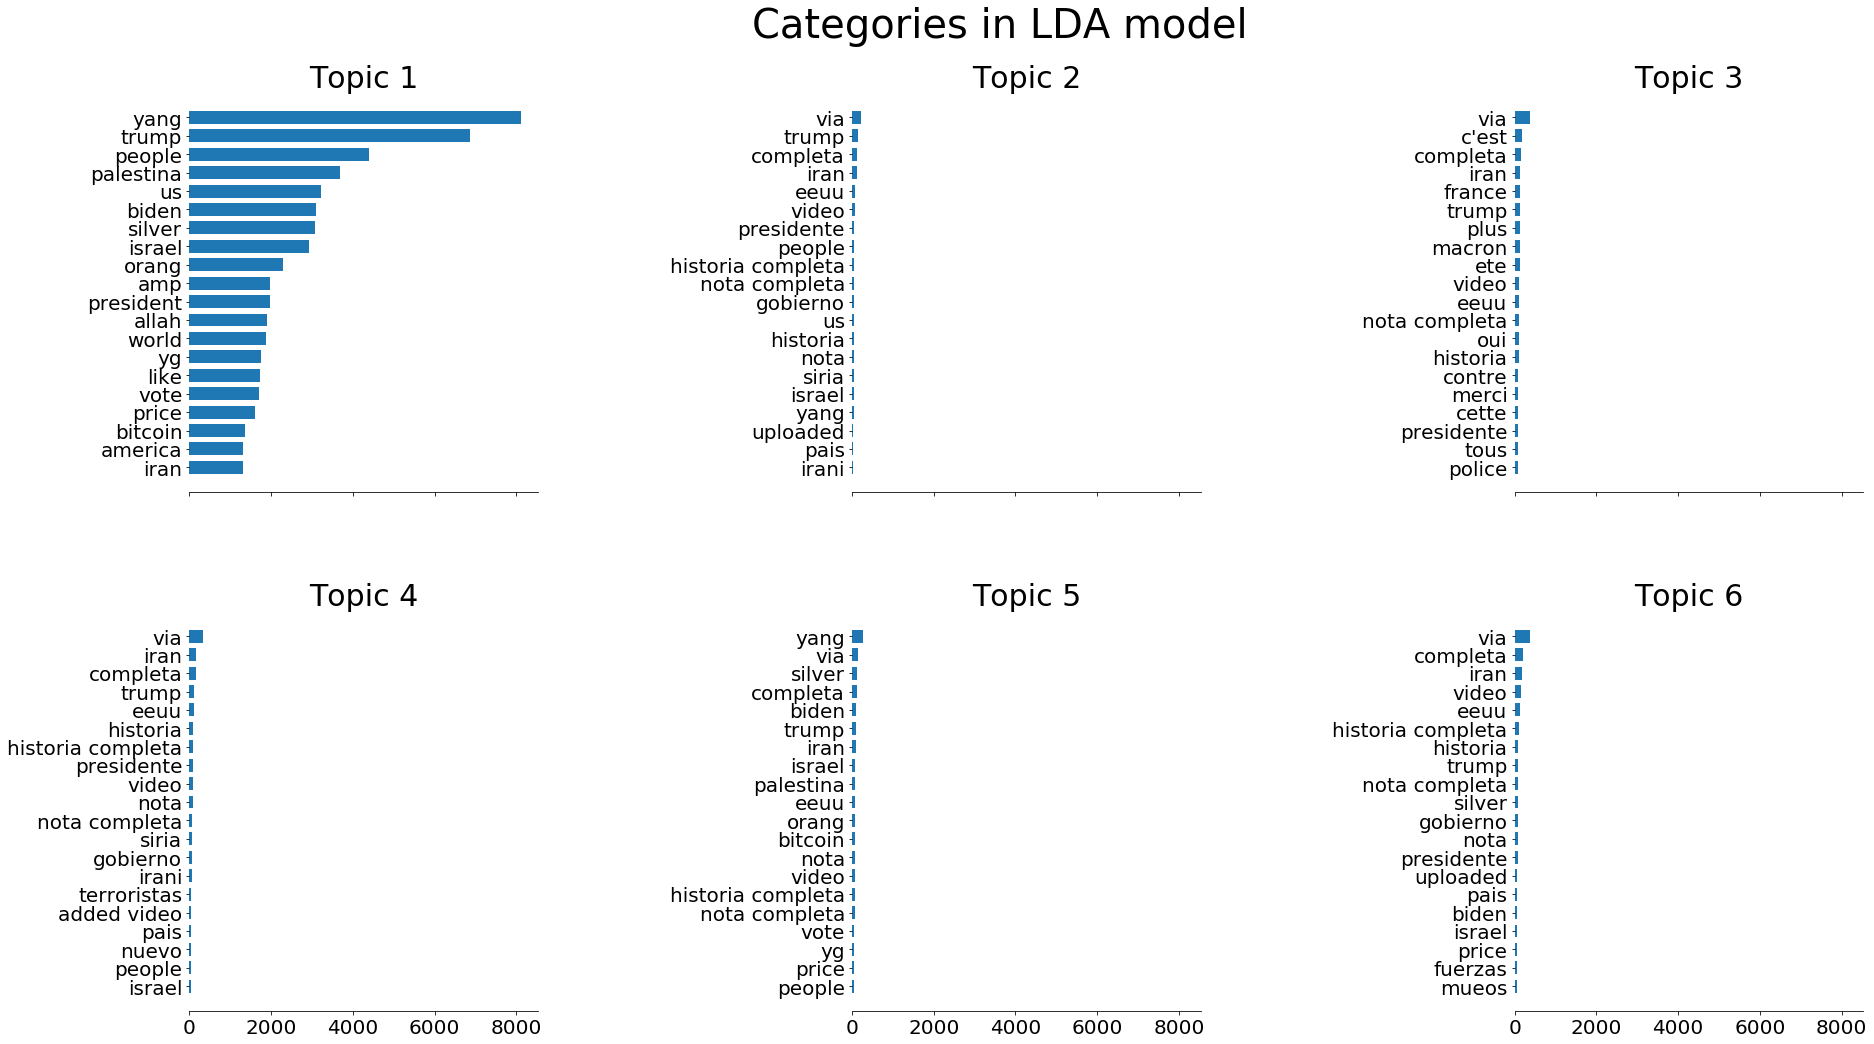

<Figure size 432x288 with 0 Axes>

In [148]:
tf_feature_names = vectorizer.get_feature_names()

plot_top_words(lda, 
               tf_feature_names, 
               n_top_words, 
               6,
               'Categories in LDA model')
plt.tight_layout()

Because the "document" level used in this case was per-user tweet token aggregates, we can perhaps consider these topics to be analogous to categories of users, based on their overall tweet set. Considering this campaign was so long, it is likely that the specific topics of tweets changed over time, so in further analysis, we might perform more filtering of the tweets in advance of clustering, for instance isolating tweets from a certain period of time.

In [ ]:
"""Variational parameters for topic word distribution. 

Since the complete conditional for topic word distribution is a 
Dirichlet, components_[i, j] can be viewed as pseudocount that 
represents the number of times word j was assigned to topic i. 
It can also be viewed as distribution over the words for each 
topic after normalization: 
model.components_ / model.components_.sum(axis=1)[:, np.newaxis].
"""
lda.components_

In [155]:
stop_words = [*stopwords.words(),
              '<-url->', '<-@->', '<-#->', 
              '...','`',',','-',"'",
              '.','^',],
preprocessor = preprocess_string
tokenizer = TweetTokenizer(preserve_case=False,
                           reduce_len=True,
                           strip_handles=True).tokenize

vectorizer = CountVectorizer(analyzer='word',
                                 strip_accents='ascii',
                                 stop_words=stop_words,
                                 preprocessor=preprocessor,
                                 ngram_range=(1,2),
                                 tokenizer=tokenizer
                                )

In [174]:
def extract_topics(documents,
                   vectorizer=None,
                   n_samples=2000,
                   n_features=1000,
                   n_components=10,
                   n_top_words=20,
                   apply_preprocessing=True,
                   stop_words=[*stopwords.words(),
                                  '<-url->', '<-@->', '<-#->', 
                                  '...','`',',','-',"'",
                                  '.','^',],
                   ):
    
    vectorizer = CountVectorizer(analyzer='word',
                                 strip_accents='ascii',
                                 stop_words=[*stopwords.words(),
                                              '<-url->', '<-@->', '<-#->', 
                                              '...','`',',','-',"'"],
                                 ngram_range=(1,2),
                                 tokenizer=TweetTokenizer(preserve_case=False,
                                           reduce_len=True,
                                           strip_handles=True).tokenize
                                )

    documents_list = (documents
                        .map(long_string)
                        .map(preprocess_string)
                     )

    print('vectorizing...')
    t1 = default_timer()
    tf = vectorizer.fit_transform(documents_list)
    
    print('elapsed: {}'.format(default_timer() - t1))
    
    
    print(('LDA:\nn_samples: {}\nn_features: {}\nn_components: {}')
          .format(n_samples, n_features, n_components))

    lda = LatentDirichletAllocation(n_components=n_components, 
                                    max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)

    lda.fit(tf)
    
    tf_feature_names = vectorizer.get_feature_names()

    plot_top_words(lda, 
                   tf_feature_names, 
                   n_top_words,
                   n_components,
                   'Categories in LDA model')
    plt.tight_layout()

In [ ]:
extract_topics(user_tweets['tweet_text'],
               n_components=6)

vectorizing...


/home/sarah/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['.', '?', '^', 'acaba', 'acesti', 'aiba', 'altal', 'altalaban', 'altms', 'amig', 'arasnda', 'arrol', 'artq', 'aslnda', 'astia', 'ate', 'aveti', 'avra', 'avro', 'azert', 'aztan', 'azutan', 'bade', 'bae', 'bar', 'baz', 'bel', 'belul', 'bes', 'bilr', 'birkac', 'birsey', 'bizlr', 'blk', 'bos', 'brzcas', 'brzkone', 'bunlarn', 'butun', 'bzi', 'bzn', 'caci', 'carei', 'caror', 'carui', 'cate', 'cati', 'catva', 'cem', 'cemer', 'cemerkoli', 'cemu', 'cemur', 'cemurkoli', 'ceprav', 'ceravno', 'cesa', 'cesar', 'cesarkoli', 'cetrta', 'cetrte', 'cetrtega', 'cetrtem', 'cetrtemu', 'cetrti', 'cetrtih', 'cetrtim', 'cetrtima', 'cetrtimi', 'cetrto', 'cetudi', 'cez', 'cezenj', 'ceznje', 'cigar', 'cigav', 'cigava', 'cigave', 'cigavega', 'cigavem', 'cigavemu', 'cigavi', 'cigavih', 'cigavim', 'cigavima', '

elapsed: 31.768784009007504
LDA:
n_samples: 2000
n_features: 1000
n_components: 6


### To do:
- mixtures of languages in topics? apply analysis to tweets separated by language?